<a href="https://colab.research.google.com/github/seank1m/artificial-intelligence-for-robotics/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Past Sections from Assignment 1

In Assignment 2, we build upon the previous assignment and perform tasks related to regression problems.

---

First, we reload the dependencies from the previous assignment:

In [1]:
%pip install -q plotly
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def plot_cloud(data=None, x='x', y='y', z='z', color=None, *, max_points=10_000, **kwargs):

    if max_points is not None and data is not None and len(data) > max_points:
        import sys
        print(f"Warning: too many points, trying to show only {max_points:,} points.", file=sys.stderr)
        skip = len(data) // max_points
        data = data[::skip]

    if isinstance(data, np.ndarray):
        m = data.shape[-1]
        if m == 3:
            x, y, z = data.T
        elif m == 4:
            x, y, z, color = data.T
        data_frame = None
    elif isinstance(data, pd.DataFrame):
        data_frame = data
    else:
        data_frame = None

    if (data_frame is not None
        and isinstance(color, str)
        and len(color) == 3
        and color not in data_frame.columns
        and all(c in data_frame.columns for c in color)
    ):
        update_color = data_frame[list(color)].to_numpy()
        color = None
    else:
        update_color = None

    fig = px.scatter_3d(
        data_frame,
        x=x, y=y, z=z,
        color=color,
        template=plot_cloud.template,
        **kwargs,
    )
    if update_color is not None:
        # has to be updated later because px.scatter_3d doesn't accept a matrix
        fig.data[0].marker.color = update_color

    return fig

plot_cloud.template = dict(
    layout=dict(
        margin=dict(
            # l=0, r=0,  # set left and right margin
            b=0, t=0,  # set bottom and top margin
        ),
        scene=dict(
            # xaxis_visible=False,  # hide axes
            # yaxis_visible=False,
            # zaxis_visible=False,
            aspectmode='data',  # set aspect ratio
        ),
    ),
    data=dict(
        scatter3d=[
            go.Scatter3d(
                marker_size=1,  # set default marker size
            ),
        ],
    ),
)

In [3]:
import math
import numpy as np
import pandas as pd

n_clusters = 1000

We now use the `request` package to download `df_test` that contains the data required for the rest of the assignment. `df_test` might be slightly different from the one you got in Assignment 1 depending on the features you used for the classification (it does not mean that the result you got in Assignment 1 is wrong).

In [4]:
import requests

# Shareable link
shareable_link = 'https://drive.google.com/file/d/1-5gZVjT5nIt4oAvTTVLk1zAmg9z55Nb1/view?usp=sharing'

# Extract file ID and create direct download URL
file_id = shareable_link.split('/')[-2]
url = f'https://drive.google.com/uc?export=download&id={file_id}'
print(f"Download URL: {url}")

# Download the file
output = 'df_test.pkl'
response = requests.get(url)
if response.status_code == 200:
    with open(output, 'wb') as f:
        f.write(response.content)
    print(f"File downloaded as '{output}'")
else:
    print(f"Failed to download. Status code: {response.status_code}")

# Load the DataFrame (for pickle files)
df_test = pd.read_pickle(output)

# Show the first few rows
df_test.head()

Download URL: https://drive.google.com/uc?export=download&id=1-5gZVjT5nIt4oAvTTVLk1zAmg9z55Nb1
File downloaded as 'df_test.pkl'


,x,y,z,intensity,r,g,b,label,cluster,pred
0,-10.747,-26.050,-0.526,425,227,231,234,buildings,98,buildings
1,-10.841,-26.017,-0.187,-1036,115,108,116,buildings,98,buildings
2,-10.593,-26.039,-1.211,-961,47,47,45,buildings,98,buildings
3,-10.039,-26.167,-1.034,-1080,152,159,167,buildings,98,buildings
4,-10.593,-26.039,-0.858,-1078,50,41,42,buildings,98,buildings


# Assignment 2

Assignment 2 will continue on from Assignment 1, using the clustered and classified point cloud. We will use linear and non-linear regression models to resample the point cloud (the marking criteria is provided in brackets):

1. Apply linear regression to buildings (30%)
2. Answer the questions related to the linear regression (20%)
3. Apply the GP for ground estimation (30%)
4. Answer the questions related to the GP section (20%)

---


You are required to:
 - Model each cluster classified as *building* with a *linear regression* model.
 - Model every point classified as *terrain* with a *Gaussian process* model.

 > Begin by inserting Assignment 1 here. Note: by shift-clicking and then right-clicking, you can select multiple notebook cells, copy, and paste them across notebooks.

 > In the subsequent tasks, use the test data set `df_test` and group the points into **100 clusters**. Do not use the ground truth class `labels`, only the predicted values `pred`.


# 1. Linear Regression

As we are working in 3 dimensions, we are going to use 2 dimensions to estimate the 3rd. As such, There are 3 possible choices for the estimated variable: $x$, $y$, or $z$. Luckily, it is easy to know which model to select: the one with the lowest *mean squared error*.

> Define a function to perform linear regression in each of the 3 dimensions, and select the model with the best error.

> Apply this process to each cluster, replacing the points with a linear approximation.

> The model can be used at arbitrary locations, use `bounding_grid` to query each model on a regular grid instead of at the original (training) locations.

In [5]:
df_walls = df_test[df_test['pred'] == 'buildings']
positions = df_walls[['x','y','z']].to_numpy()
assignment = df_walls['cluster'].to_numpy()
print(positions)

[[-10.747 -26.05   -0.526]
 [-10.841 -26.017  -0.187]
 [-10.593 -26.039  -1.211]
 ...
 [ -7.912   5.425   9.331]
 [ -7.394   5.24    9.048]
 [-15.507   8.041  11.559]]


In [6]:
def bounding_grid(x, n=None):
    """
    Replaces a set of points by a similar number of points on a regular grid
    spanning the bounds of the original point set.

    x: numpy array, shape [n, d], n points in d dimensions.
    n: int (optional), minimum number of points to generate.
    """
    d = x.shape[-1]
    if n is None:
        n = len(x)
    mins = x.min(axis=0)
    maxs = x.max(axis=0)
    rngs = (maxs - mins)
    nums = np.ceil(rngs * np.power(n/rngs.prod(), 1/d)).astype(int)
    axes = [np.linspace(mn, mx, ns) for mn, mx, ns in zip(mins, maxs, nums)]
    grid = np.stack(np.meshgrid(*axes, indexing='ij'), axis=-1)
    return grid.reshape(nums.prod(), d)

In [7]:
## TODO START
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

learning_rate = 0.01
num_epochs = 1000
batch_size = 32
input_dim = 1
output_dim = 1

def lin_reg(points):
# .............. ##TODO ................

      if(len(points) == 0):
        print("No data available")
        return points

      if len(points) >= 3:
        points = bounding_grid(points)


      # Convert the data to pytorch tensors
      x = torch.as_tensor(points[:,0]).float()
      y = torch.as_tensor(points[:,1]).float()
      z = torch.as_tensor(points[:,2]).float()

      print(f'x: {x}')
      print(f'y : {y}')
      print(f'z : {z}')

      x = x.reshape(-1, 1)
      y = y.reshape(-1, 1)
      z = z.reshape(-1, 1)

      zy = torch.cat((z, y), 1)
      xy = torch.cat((x, y), 1)
      xz = torch.cat((x, z), 1)
      print(f'zy: {zy}')
      print(f'xy: {xy}')
      print(f'xz: {xz}')

      x_model = LinearRegression().fit(zy, x)
      y_model = LinearRegression().fit(xz, y)
      z_model = LinearRegression().fit(xy, z)

      x_pred = x_model.predict(zy)
      y_pred = y_model.predict(xz)
      z_pred = z_model.predict(xy)

      # Mean squared error

      x_mse = mean_squared_error(x, x_pred)
      y_mse = mean_squared_error(y, y_pred)
      z_mse = mean_squared_error(z, z_pred)

      print(f'X MSE: {x_mse}')
      print(f'Y MSE: {y_mse}')
      print(f'Z MSE: {z_mse}')

      # Check which data set has the lowest MSE
      if x_mse < y_mse and x_mse < z_mse:
        test = zy
        model = x_model
        index = 0
        print("X dataset has lowest MSE")
      elif y_mse < x_mse and y_mse < z_mse:
        test = xz
        model = y_model
        index = 1
        print("Y dataset has lowest MSE")
      elif z_mse < x_mse and z_mse < y_mse:
        test = xy
        model = z_model
        index = 2
        print("Z dataset has lowest MSE")
      else:
        print("MSE Error")

      return points

      pred = model.predict(test)
      pred = pred.reshape(points[:,index].shape)

      points[:, index] = pred

      return points

## TODO END

positions_lin = []
for i in range(n_clusters):
  ##TODO
    print(n_clusters)
    print(assignment)
    points = positions[assignment == i]
    print("Cluster: " + str(i))

    points_lin = lin_reg(points)
    positions_lin.append(points_lin)
positions_lin = np.concatenate(positions_lin)

plot_cloud(positions).show()
plot_cloud(positions_lin).show()

Streaming output truncated to the last 5000 lines.
        [-11.2280,  -0.6400],
        [-11.2280,  -0.6400],
        [-11.2280,  -0.6400]])
xz: tensor([[-12.6010,   3.2800],
        [-12.6010,   3.7790],
        [-12.6010,   4.2780],
        [-12.6010,   4.7770],
        [-12.6010,   5.2760],
        [-12.6010,   3.2800],
        [-12.6010,   3.7790],
        [-12.6010,   4.2780],
        [-12.6010,   4.7770],
        [-12.6010,   5.2760],
        [-12.6010,   3.2800],
        [-12.6010,   3.7790],
        [-12.6010,   4.2780],
        [-12.6010,   4.7770],
        [-12.6010,   5.2760],
        [-12.1433,   3.2800],
        [-12.1433,   3.7790],
        [-12.1433,   4.2780],
        [-12.1433,   4.7770],
        [-12.1433,   5.2760],
        [-12.1433,   3.2800],
        [-12.1433,   3.7790],
        [-12.1433,   4.2780],
        [-12.1433,   4.7770],
        [-12.1433,   5.2760],
        [-12.1433,   3.2800],
        [-12.1433,   3.7790],
        [-12.1433,   4.2780],
        [-12.1

# 2. Linear regression Questions (In less than 100 words each):
- How shall we estimate the performance of the linear regression?
- What could we do if the the fitting of the plane was not good enough?
- How can we tell if the model is overfitting or underfitting our data?

1. *How shall we estimate the performance of the linear regression?*


*  **We can estimate performance using regression metrics such as mean squared error (MSE) which is the average of the squared differences between predicted and expected target values in a dataset. MSE is also the loss function which linear regression minimises during training. We can also use mean absolute error (MAE) to find the average of the absolute error values**

2. *What could we do if the the fitting of the plane was not good enough?*


* **To improve poor fitting, we can use regularisation, modifying our cost function J to add preference for certain parameter values. It helps handling multicollinearity to have more stable illustrations.**

3. *How can we tell if the model is overfitting or underfitting our data?*

* **In week 4 tutorials, symptoms of underfitting include high training error, training error close to test error and high bias. On the other hand, we can tell if the model is overfitting data if it has very low training error, training error much lower than test error and high variance. The uniform shapes of the model suggests that our model is fitting just right**






# 3. Gaussian Process Regression

Similarly, Gaussian process models can be used in higher dimensions too. Model the ground with a GP, where the height is the estimated quantity.

> Perform Gaussian process regression on the height data.

> Note: we are no longer working with zero-mean data, and the kernel hyperparameters should be  chosen carefully.

> With the 2-dimensional input, the kernel function needs to change: it should take 2D vectors and return scalars.

> The training data should be considered noisy, with a standard deviation of 1cm (point cloud units are in meters).

> The model can be used at arbitrary locations, use `bounding_grid` to query the model on a regular grid instead of at the original (training) locations.

In [8]:
df_ground = df_test[df_test['pred'] == 'terrain']
locations = df_ground[['x','y']].to_numpy()
heights = df_ground['z'].to_numpy()

In [9]:
# See the mean and variance of the modelled property
mu = np.mean(heights)
sigma= np.std(heights)

print (mu, sigma)


-1.5492486033519555 0.08567136889165507


In [10]:
from numpy import exp, sqrt, sum
from numpy import diag, eye
from numpy.linalg import inv, solve

lengthscale =  1.0 # TODO

def kernel(x1, x2, sigma=1.0, lengthscale=1.0):

    #x1: (n1, 2) array of 2D points
    #x2: (n2, 2) array of 2D points
    #Returns: (n1, n2) kernel matrix

    sq_dist = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)

    return sigma**2 * np.exp(-0.5 * sq_dist / lengthscale**2)

In [14]:
## inputs

# Location of data points
xd = locations
# Value of data points
yd = heights
# Number of data points
nd = len(xd)
# Query locations
xq = bounding_grid(xd)

std_n = 0.01
## evaluating the kernel
#TODO
Kdd = kernel(xd, xd)
Kqd = kernel(xq, xd)
Kdq = kernel(xd, xq)
Kqq = kernel(xq, xq)

# [:,None]

print("Kqd shape:", Kqd.shape)
print("Kdd shape:", Kdd.shape)
# print("Snn shape:", Snn.shape)
print("yd shape:", yd.shape)
print("mu shape:", mu.shape)

## the GP equations
#TODO
Snn = std_n**2 * eye(nd)
mean_q = mu + Kqd @ inv(Kdd + Snn) @ (yd - mu)
cov_qq = Kqq - Kqd @ inv(Kdd + Snn) @ Kdq
var_q  = diag(cov_qq)  # TODO
std_q  = sqrt(var_q) #TODO

Kqd shape: (378, 358)
Kdd shape: (358, 358)
yd shape: (358,)
mu shape: ()


Plot the estimated height of the ground alongside with the uncertainty:

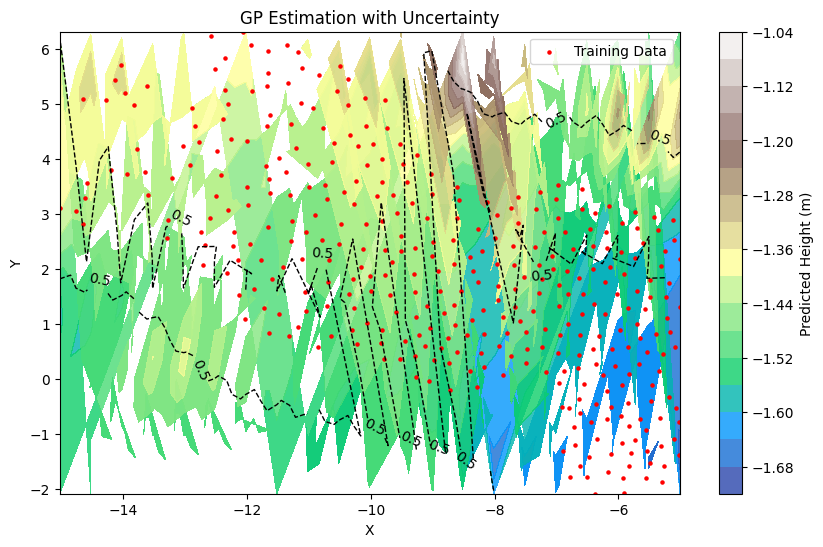

In [15]:
# TODO
# plot the ground truth

plot_cloud(x=xd[:,0], y=xd[:,1], z=yd).show()
plot_cloud(x=xq[:,0], y=xq[:,1], z=mean_q, color=std_q).show()

# then plot the estimation with the uncertainty

from matplotlib import pyplot as plt




grid_shape = (len(np.unique(xq[:, 1])), len(np.unique(xq[:, 0])))  # (ny, nx)
xx = xq[:, 0].reshape(grid_shape)  # grid_shape = (nx, ny)
yy = xq[:, 1].reshape(grid_shape)
zz_mean = mean_q.reshape(grid_shape)
zz_std = std_q.reshape(grid_shape)

# Create plot
plt.figure(figsize=(10, 6))

# Mean prediction (filled contours)
plt.contourf(xx, yy, zz_mean, levels=20, cmap='terrain', alpha=0.8)
cbar = plt.colorbar(label='Predicted Height (m)')

# Uncertainty contours (±1σ, ±2σ)
cs = plt.contour(xx, yy, zz_std,
                 levels=[0.5*np.max(zz_std), np.max(zz_std)],  # Adjust levels as needed
                 colors='k', linestyles='--', linewidths=1)
plt.clabel(cs, inline=True, fontsize=10)

# Overlay training points (optional)
plt.scatter(xd[:, 0], xd[:, 1], c='r', s=5, label='Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('GP Estimation with Uncertainty')
plt.legend()
plt.show()


# 4. GP Questions (In less than 100 words each):
- What is happening in the area where no points are rpovided to the GP (discuss the mean values and the uncertainty)?
- Which kernel we are using and why this is important?




1. In the area where no points are provided to the GP, the mean values are assumed to be zero by the GP. In the absence of data, the model's prediction will revert to this prior mean. In addition, regions without data will affect the uncertainty as it increases with distance from data, reaching maximum variance.

2. We are using the RBF kernel for this Gaussian process. This is important as it has effects on the flexibility, computational cost and determines whether it needs a fixed number of parameters. In a Gaussian Process, a non-parametric model is used meaning it is very flexible and complexity grows with data so no fixed parameters. However, it can become slow depending on data size.